## **Científico de datos en NEQUI: Prueba Técnica**
### Yeison Andrés Correa Castaño

**Objetivo:** El objetivo de la prueba es idear una solución para identificar transacciones que evidencian un
comportamiento de Mala Práctica Transaccional.

### Importar librerias necesarias

In [3]:
import pandas as pd
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

### Cargar y limpiar los datos

In [ ]:
url_1 = "sample_data_0006_part_00.parquet"

df_1 = pd.read_parquet(url_1)
df_1.head()

In [ ]:
# Convertir la columna a tipo datetime y formatear la fecha como YYYYMMDD
df_1['transaction_date'] = pd.to_datetime(df_1['transaction_date']).dt.strftime('%Y%m%d')

# Contar la cantidad de transacciones por día
daily_counts = df_1['transaction_date'].value_counts().sort_index()

# Mostrar los resultados en el formato deseado
for date, count in daily_counts.items():
    print(f"{date} {count}")

In [113]:
df_1['transaction_date'] = pd.to_datetime(df_1['transaction_date'])

# Definir el rango de fechas
start_date = "2021-06-11"
end_date = "2021-06-22"

# Filtrar los datos dentro del rango de fechas
filtered_df = df_1[(df_1['transaction_date'] >= start_date) & (df_1['transaction_date'] <= end_date)]

In [114]:
filtered_df.to_csv('data.csv')

### Leer base de datos

In [4]:
data = pd.read_csv('data.csv')

In [5]:
# Cargar los datos desde un archivo CSV (reemplaza la ruta con tu archivo)
df = pd.read_csv('data.csv')

# Convertir la columna transaction_date a tipo datetime
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

# Convertir los montos de transacciones a float
df['transaction_amount'] = df['transaction_amount'].astype(float)

# Eliminar duplicados (si los hay)
df = df.drop_duplicates()

df.head()


,Unnamed: 0,merchant_id,_id,subsidiary,transaction_date,account_number,user_id,transaction_amount,transaction_type
0,127249,075d178871d8d48502bf1f54887e52fe,8ea6a30060591a18cf5dc40affada997,db2eef9b96323e5a518484631789d464,2021-06-11,ea65109b8f9f1e8e36cb3603d0e4e880,1f64253dc29b32a55f44c37f3770151b,171.200304,CREDITO
1,127250,075d178871d8d48502bf1f54887e52fe,a19383e01995dac973d24a60828cb048,c2f62d03ef7784a8f4c087a496922840,2021-06-11,d3bca5f7a370953d7c83b13d91bed60d,4ae95ef03927830047298c9dc1ef891a,17.833365,CREDITO
2,127251,075d178871d8d48502bf1f54887e52fe,3efd30650bc82e1c2e0a7a9d67d2eef7,4267803441c84b90cd56b5382ab5b8a7,2021-06-11,5b9969d7e6d81bb74ff13a75b23df2a3,6431decbadc2614a424f3b18da58d4f3,475.556401,CREDITO
3,127252,075d178871d8d48502bf1f54887e52fe,0e5c46e0362af1e9668ae3829bd5eeee,f1fb35c5064925cdfb48361b7035a177,2021-06-11,cf49522ce9259c9816a06b6dae777871,6bd42b856f9848f1ab68ce958889033b,19.022256,CREDITO
4,127253,075d178871d8d48502bf1f54887e52fe,926122f7fe818966f5257fd130c06da8,824b2af470cbe6a65b15650e03b740fc,2021-06-11,e24c6ba0a183e1a553ae17e8bc78a1a5,c5605508d286b3e465c745534935acbc,139.100247,CREDITO


In [6]:
df.shape

(388904, 9)

## **Paso 1: Alcance del proyecto.**

### Agrupar y sumar transacciones

In [7]:
# Calcular transacción promedio para clientes no sospechosos
non_suspicious_mean = df['transaction_amount'].median()
print(f"Transacción media para clientes no sospechosos: {non_suspicious_mean}")

Transacción media para clientes no sospechosos: 118.88910024


Una transaccion media de 119 es no sospechosa, tenemos que encontrar los clientes que hacen varias transferencias para llegar a esta cifra en un día.

In [24]:
# Crear una columna de ventana de 24 horas
df['transaction_hour'] = df['transaction_date'].dt.floor('24h')

# Agrupar por account_number y ventana de 24 horas, y calcular suma, media, mediana y conteo de transacciones
grouped_df = df.groupby(['account_number', 'transaction_hour']).agg(
    total_transaction_amount=('transaction_amount', 'sum'),
    median_transaction_amount=('transaction_amount', 'median'),
    transaction_count=('transaction_amount', 'count')
).reset_index()

grouped_df.head()


,account_number,transaction_hour,total_transaction_amount,median_transaction_amount,transaction_count
0,00003f36588d54059d46b91978c6333f,2021-06-22,59.444550,59.444550,1
1,000061714f1bd279c9dbeeabe29fcd01,2021-06-12,594.445501,594.445501,1
2,00008e655349530a90b26b869f63f9a2,2021-06-12,356.667301,356.667301,1
3,00008e655349530a90b26b869f63f9a2,2021-06-18,237.778200,237.778200,1
4,000145c89e3faae99d09731414395e5a,2021-06-12,118.889100,118.889100,1


### Análisis de la distribución de los montos

In [31]:
# Calcular estadísticas
mean_amount = grouped_df['total_transaction_amount'].median()
std_amount = grouped_df['total_transaction_amount'].std()

mean_trx = grouped_df['transaction_count'].median()
std_trx = grouped_df['transaction_count'].std()

print(f"Mediana montos: {mean_amount}")
print(f"Desviación Estándar montos: {std_amount}")

print("---------------------------------------------------")

print(f"Mediana transacciones: {mean_trx}")
print(f"Desviación Estándar Transacciones: {std_trx}")




Mediana montos: 118.88910024
Desviación Estándar montos: 310.2615891198818
---------------------------------------------------
Mediana transacciones: 1.0
Desviación Estándar Transacciones: 0.3807133203712452


### Identificar transacciones sospechosas


La elección del umbral basado en 3 desviaciones estándar es un enfoque heurístico, lo que significa que se utiliza una regla general basada en la experiencia y práctica general en análisis de datos para solucionar un problema específico. Este tipo de método no es exacto, pero puede ser muy efectivo para identificar patrones y outliers en datos con comportamiento similar a la distribución normal.

Al usar 3 desviaciones estándar, aprovechamos el conocimiento estadístico de que en una distribución normal, todo lo que cae fuera de ese rango es menos del 1%. Por ende, esas transacciones se podrían considerar inusuales o sospechosas.

El rango (40%-60%) se utiliza para centrarse en clientes que operan con montos totales en ese intervalo, lo que se asume podría indicar un comportamiento sospechoso.

Se combinan tres condiciones para marcar transacciones sospechosas:

- **Montos moderados:** La cantidad total transaccionada por el cliente está dentro del rango intermedio (30%-70%).
- **Alta frecuencia:** El cliente realiza un número de transacciones mayor que el umbral definido previamente (threshold)

In [100]:
# Definir el umbral como 3 desviaciones estándar por encima de la media de la cantidad de las transacciones
threshold= mean_trx + 3 * std_trx

# Utilizar percentiles para definir márgenes basados en la distribución de los datos
lower_bound = np.percentile(grouped_df['total_transaction_amount'], 30)
upper_bound = np.percentile(grouped_df['total_transaction_amount'], 70)

grouped_df['suspicious'] = (grouped_df['median_transaction_amount'] >= lower_bound) & (grouped_df['median_transaction_amount'] <= upper_bound) & (grouped_df['transaction_count'] > threshold)
suspicious_transactions = grouped_df[grouped_df['suspicious'] == True]
print(f"Con percentiles entre (40%-60%):")
suspicious_transactions.head()

Con percentiles entre (40%-60%):


,account_number,transaction_hour,total_transaction_amount,median_transaction_amount,transaction_count,suspicious,transaction_to_amount_ratio,anomaly,fraccionamiento
71,000d8c19f0a582fa5405c14c3898ab4c,2021-06-15,416.111851,118.88910,3,True,0.025234,0,0
92,00108481afbb7f3629b7212ea4fbe48c,2021-06-15,618.223321,118.88910,3,True,0.025234,0,0
413,004d628e16e315dcc12dc712e8818ea4,2021-06-12,891.668252,118.88910,3,True,0.025234,0,0
535,0065b7c4ccdffa826042038b7631d12d,2021-06-15,321.000571,59.44455,3,True,0.050467,0,0
900,00b296e919ab4cd8c9a1707f8a96901b,2021-06-17,202.111470,59.44455,3,True,0.050467,0,0


Por este sistema de reglas ya tenemos las cuentas de clientes con transacciones sospechosas

## **Paso 2: Explorar y evaluar los datos, el EDA.**

In [107]:
# Descripción estadística de las dos variables
grouped_df[['total_transaction_amount', 'transaction_count']].describe()

,total_transaction_amount,transaction_count
count,352496.000000,352496.000000
mean,214.156405,1.103286
std,310.261589,0.380713
min,5.944455,1.000000
25%,47.555640,1.000000
50%,118.889100,1.000000
75%,237.778200,1.000000
max,9630.017120,11.000000


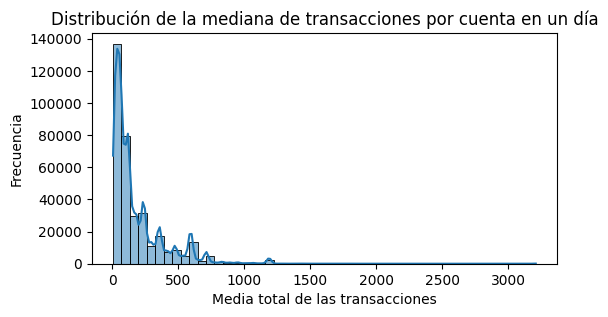

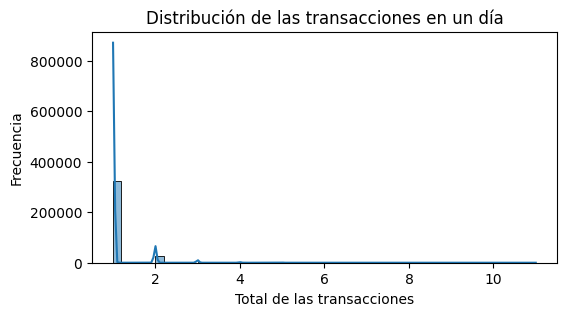

In [108]:
# Visualizar la distribución de los montos de transacciones
plt.figure(figsize=(6, 3))
sns.histplot(grouped_df['median_transaction_amount'], bins=50, kde=True)
plt.title('Distribución de la mediana de transacciones por cuenta en un día')
plt.xlabel('Media total de las transacciones')
plt.ylabel('Frecuencia')
plt.show()

# Visualizar la distribución de las transacciones
plt.figure(figsize=(6, 3))
sns.histplot(grouped_df['transaction_count'], bins=50, kde=True)
plt.title('Distribución de las transacciones en un día')
plt.xlabel('Total de las transacciones')
plt.ylabel('Frecuencia')
plt.show()

#### Distribución de transacciones

- **Distribución sesgada a la derecha:** La mayoría de las transacciones tienden a ser de montos relativamente bajos, lo que es evidente en la alta frecuencia de transacciones en el rango de 0 a 200.

- **Disminución gradual:** A medida que el monto de las transacciones aumenta, la frecuencia de dichas transacciones disminuye drásticamente. Esto indica que las transacciones de alto monto son menos comunes.

- **Outliers:** Hay transacciones que superan significativamente los montos comunes, representados por los puntos alejados a la derecha del gráfico.

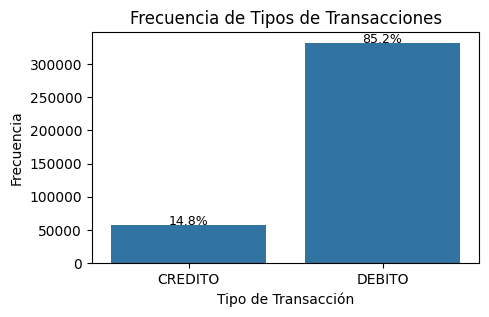

In [109]:
# Configuración de la gráfica
plt.figure(figsize=(5, 3))
ax = sns.countplot(x='transaction_type', data=df)
plt.title('Frecuencia de Tipos de Transacciones')
plt.xlabel('Tipo de Transacción')
plt.ylabel('Frecuencia')

# Añadir porcentajes 
for p in ax.patches:
    height = p.get_height()
    percentage = '{:.1f}%'.format(100 * height / len(df))
    ax.text(p.get_x() + p.get_width() / 2., height + 1, percentage, ha='center', size=9)

plt.show()

La mayor parte de las transacciones (85.2%) son de tipo débito, lo que indica que la mayoría de las operaciones realizadas implican el retiro o transferencia de fondos y solo el 14.8% de las transacciones son de tipo crédito. Esto puede sugerir un patrón donde los créditos son ligeramente menos comunes, o reflejar la naturaleza específica del uso de los servicios financieros en cuestión.

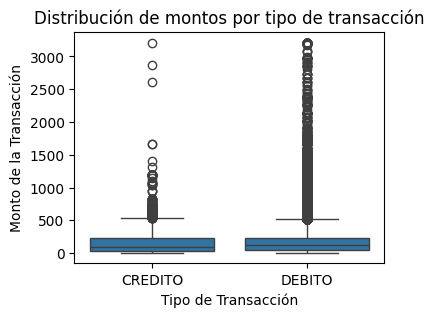

In [110]:
plt.figure(figsize=(4, 3))
sns.boxplot(x='transaction_type', y='transaction_amount', data=df)
plt.title('Distribución de montos por tipo de transacción')
plt.xlabel('Tipo de Transacción')
plt.ylabel('Monto de la Transacción')
plt.show()

#### Distribución de montos de transacciones

Crédito:

- Menor Dispersión: Los montos de las transacciones de crédito tienen una menor variabilidad en comparación con las transacciones de débito.
- Outliers Reducidos: Hay pocos valores atípicos (outliers) indicando menos transacciones inusuales.

Débito:

- Mayor Dispersión: Las transacciones de débito muestran una mayor variabilidad en los montos,tiene desde valores bajos hasta montos significativamente más altos.
- Numerosos Outliers: La presencia de varios outliers refleja transacciones debitadas significativamente más altas, en la cual se pueden detectar posibles fraudes o comportamientos anormales.

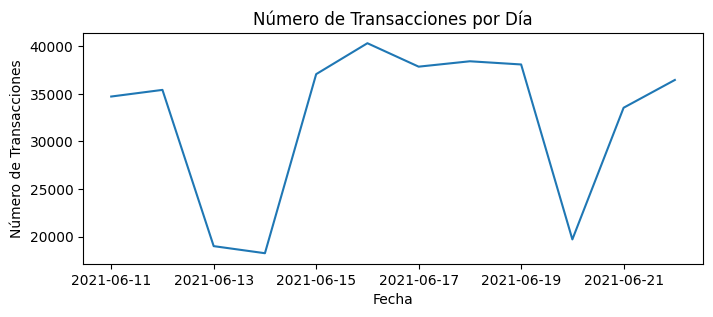

In [111]:
df['date_only'] = df['transaction_date'].dt.date
transactions_per_day = df.groupby('date_only').size()

plt.figure(figsize=(8, 3))
transactions_per_day.plot()
plt.title('Número de Transacciones por Día')
plt.xlabel('Fecha')
plt.ylabel('Número de Transacciones')
plt.show()


Los días 15 de junio de 2021 y 21 de junio de 2021 muestran picos pronunciados en las transacciones, lo que podría estar relacionado con pagos de nómina, promociones, pagos recurrentes, o eventos estacionales.

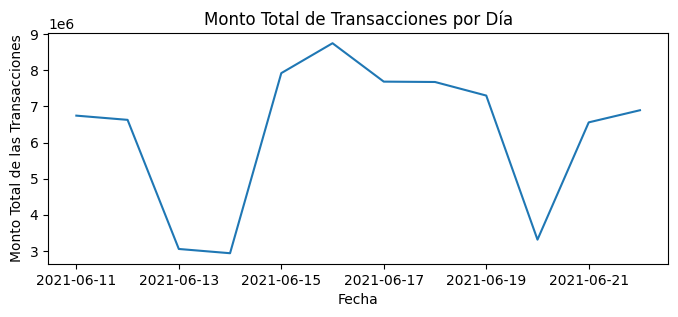

In [112]:
total_amount_per_day = df.groupby('date_only')['transaction_amount'].sum()

plt.figure(figsize=(8, 3))
total_amount_per_day.plot()
plt.title('Monto Total de Transacciones por Día')
plt.xlabel('Fecha')
plt.ylabel('Monto Total de las Transacciones')
plt.show()


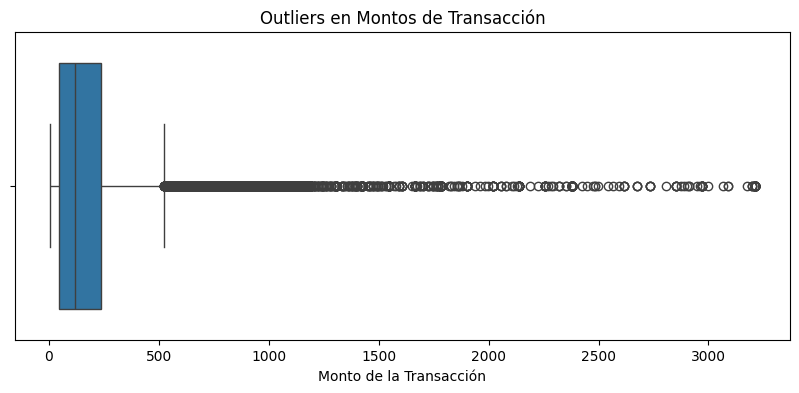

In [113]:
plt.figure(figsize=(10, 4))
sns.boxplot(x='transaction_amount', data=df)
plt.title('Outliers en Montos de Transacción')
plt.xlabel('Monto de la Transacción')
plt.show()

#### Distribución y Valores Atípicos (Outliers)

- Concentración de Montos Bajos: La mayoría de las transacciones se concentran en un rango de montos relativamente bajos, por debajo de 500 

- Valores Atípicos Significativos: Hay una cantidad considerable de outliers, que se extienden hasta más de 3000. Estos valores atípicos indican transacciones con montos significativamente más altos que la media.

## **Paso 3: Definir el Modelo Analítico**

#### 1. Trazar el flujo de datos y seleccionar el modelo final




In [114]:
# Calcular una nueva característica que representa la "frecuencia de transacciones por  mediana de monto"
grouped_df['transaction_to_amount_ratio'] = grouped_df['transaction_count'] / grouped_df['median_transaction_amount']
grouped_df.head()

,account_number,transaction_hour,total_transaction_amount,median_transaction_amount,transaction_count,suspicious,transaction_to_amount_ratio,anomaly,fraccionamiento
0,00003f36588d54059d46b91978c6333f,2021-06-22,59.444550,59.444550,1,False,0.016822,0,0
1,000061714f1bd279c9dbeeabe29fcd01,2021-06-12,594.445501,594.445501,1,False,0.001682,0,0
2,00008e655349530a90b26b869f63f9a2,2021-06-12,356.667301,356.667301,1,False,0.002804,0,0
3,00008e655349530a90b26b869f63f9a2,2021-06-18,237.778200,237.778200,1,False,0.004206,0,0
4,000145c89e3faae99d09731414395e5a,2021-06-12,118.889100,118.889100,1,False,0.008411,0,0


### Modelamiento

In [115]:
from sklearn.ensemble import IsolationForest

# Entrenamos el modelo con las características relevantes
model = IsolationForest(contamination=0.005)  # Ajusta 'contamination' según la tasa esperada de anomalías
model.fit(grouped_df[[ 'transaction_count', 'transaction_to_amount_ratio']])

# Predecir las anomalías
grouped_df['anomaly'] = model.predict(grouped_df[[ 'transaction_count', 'transaction_to_amount_ratio']])
grouped_df['anomaly'] = grouped_df['anomaly'].apply(lambda x: 1 if x == -1 else 0)  # Convertir anomalías a 1
grouped_df.head()

,account_number,transaction_hour,total_transaction_amount,median_transaction_amount,transaction_count,suspicious,transaction_to_amount_ratio,anomaly,fraccionamiento
0,00003f36588d54059d46b91978c6333f,2021-06-22,59.444550,59.444550,1,False,0.016822,0,0
1,000061714f1bd279c9dbeeabe29fcd01,2021-06-12,594.445501,594.445501,1,False,0.001682,0,0
2,00008e655349530a90b26b869f63f9a2,2021-06-12,356.667301,356.667301,1,False,0.002804,0,0
3,00008e655349530a90b26b869f63f9a2,2021-06-18,237.778200,237.778200,1,False,0.004206,0,0
4,000145c89e3faae99d09731414395e5a,2021-06-12,118.889100,118.889100,1,False,0.008411,0,0



Ya contamos con dos modelos: uno basado en un método heurístico, que mediante un ajuste de reglas permite identificar cuentas con transacciones sospechosas, y otro basado en un modelo de *Isolation Forest*, que identifica anomalías en las transacciones. Al combinar estos dos enfoques, podemos concluir que si una transacción es tanto sospechosa como anómala, existe una alta probabilidad de que esté relacionada con una **mala práctica transaccional**.


In [116]:
# Crear la columna 'fraccionamiento' basada en las condiciones
grouped_df['fraccionamiento'] = ((grouped_df['anomaly'] == 1) & (grouped_df['suspicious'] == True)).astype(int)

In [117]:
grouped_df.head()

,account_number,transaction_hour,total_transaction_amount,median_transaction_amount,transaction_count,suspicious,transaction_to_amount_ratio,anomaly,fraccionamiento
0,00003f36588d54059d46b91978c6333f,2021-06-22,59.444550,59.444550,1,False,0.016822,0,0
1,000061714f1bd279c9dbeeabe29fcd01,2021-06-12,594.445501,594.445501,1,False,0.001682,0,0
2,00008e655349530a90b26b869f63f9a2,2021-06-12,356.667301,356.667301,1,False,0.002804,0,0
3,00008e655349530a90b26b869f63f9a2,2021-06-18,237.778200,237.778200,1,False,0.004206,0,0
4,000145c89e3faae99d09731414395e5a,2021-06-12,118.889100,118.889100,1,False,0.008411,0,0


In [118]:
grouped_df[grouped_df['fraccionamiento'] == 1]

,account_number,transaction_hour,total_transaction_amount,median_transaction_amount,transaction_count,suspicious,transaction_to_amount_ratio,anomaly,fraccionamiento
1453,011bc487106bca7b28c95f10c4708ab2,2021-06-13,582.556591,59.444550,5,True,0.084112,1,1
1688,014777ec697863948132cc66adcd9d82,2021-06-17,832.223702,166.444740,5,True,0.030040,1,1
5119,03ca69e14f9cecf545990123631f6c34,2021-06-11,796.556972,202.111470,4,True,0.019791,1,1
5783,044b7ed2bb52454330ae8a1e7279723a,2021-06-20,939.223892,59.444550,5,True,0.084112,1,1
5861,045fb75ce6f429492e3be4e66c776382,2021-06-13,796.556972,89.166825,4,True,0.044860,1,1
...,...,...,...,...,...,...,...,...,...
350648,fe992293509bead0c465f101a5f4cd38,2021-06-17,237.778200,59.444550,4,True,0.067290,1,1
350662,fe9b0bd96668df66dfb086bf47e0a56c,2021-06-19,582.556591,59.444550,5,True,0.084112,1,1
350765,feb0ccea743281dec8ee3bf5ea76c86f,2021-06-20,844.112612,160.500285,4,True,0.024922,1,1
352087,ffb224f6c4c190c486eda3b888c3e118,2021-06-11,796.556972,89.166825,4,True,0.044860,1,1


In [119]:
# Filtrar clientes sospechosos
suspicious_clients = grouped_df[grouped_df['fraccionamiento'] == 1]['fraccionamiento'].unique()


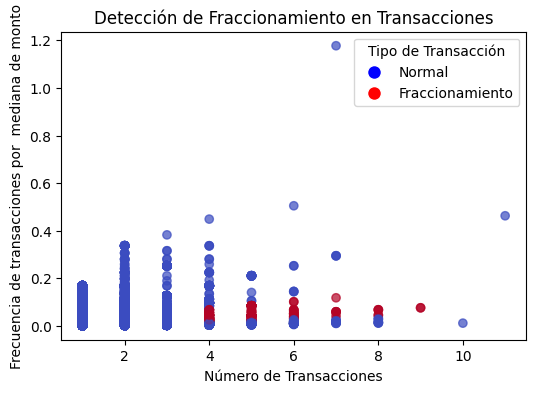

In [121]:
import matplotlib.pyplot as plt

# Crear la gráfica
plt.figure(figsize=(6, 4))
scatter = plt.scatter(
    grouped_df['transaction_count'], 
    grouped_df['transaction_to_amount_ratio'], 
    c=grouped_df['fraccionamiento'], 
    cmap='coolwarm', 
    alpha=0.7,
    label='fraccionamiento'
)

# Agregar etiquetas y título
plt.xlabel('Número de Transacciones')
plt.ylabel('Frecuencia de transacciones por  mediana de monto')
plt.title('Detección de Fraccionamiento en Transacciones')

# Crear una leyenda personalizada
legend_labels = {0: "Normal", 1: "Fraccionamiento"}
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label=legend_labels[0]),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label=legend_labels[1]),
]
plt.legend(handles=handles, title="Tipo de Transacción")

# Mostrar la gráfica
plt.show()


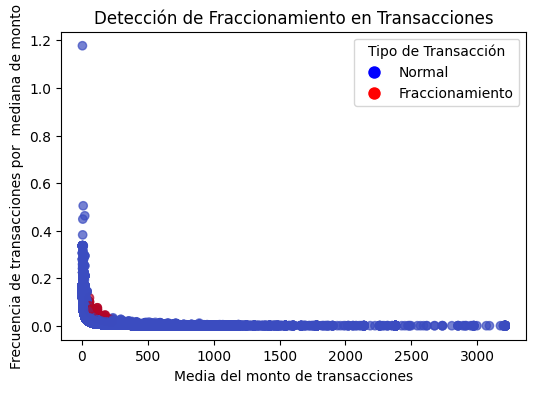

In [123]:
plt.figure(figsize=(6, 4))
scatter = plt.scatter(
    grouped_df['median_transaction_amount'], 
    grouped_df['transaction_to_amount_ratio'], 
    c=grouped_df['fraccionamiento'], 
    cmap='coolwarm', 
    alpha=0.7,
    label='fraccionamiento'
)

# Agregar etiquetas y título
plt.xlabel('Media del monto de transacciones')
plt.ylabel('Frecuencia de transacciones por  mediana de monto')
plt.title('Detección de Fraccionamiento en Transacciones')

# Crear una leyenda personalizada
legend_labels = {0: "Normal", 1: "Fraccionamiento"}
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label=legend_labels[0]),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label=legend_labels[1]),
]
plt.legend(handles=handles, title="Tipo de Transacción")

# Mostrar la gráfica
plt.show()

#### Justificación del modelo seleccionado: **Modelo combinado**

**Método Heurístico**: Utilizamos reglas heurísticas basadas en estadísticas descriptivas para detectar transacciones inusuales. Este enfoque es directo y rápido para implementaciones iniciales.

**Modelos de Machine Learning:** Modelos no supervisados como Isolation Forest identifican patrones de transacciones anómalas sin etiquetado previo. Este método es efectivo cuando se trata de detectar comportamientos atípicos en grandes conjuntos de datos.

**Modelo combinado:**  La combinación de heurísticas y machine learning proporciona un enfoque robusto, donde las reglas de negocio y los modelos estadísticos trabajan en conjunto para maximizar la detección de anomalías y minimizar falsos positivos.

### 2. Frecuencia de Actualización de los Datos

- Diaria: Actualizar los datos y el modelo cada 24 horas. Esto asegura una detección oportuna de comportamientos sospechosos y permite a los analistas revisar las alertas y tomar acciones preventivas rápidamente.

Dado que las malas prácticas transaccionales a menudo se detectan en un marco de tiempo de 24 horas, esta frecuencia permite identificar patrones sospechosos dentro de este período sin sobrecargar los recursos de procesamiento.

### 3. Diseñar una Arquitectura Ideal y Recursos Necesarios 

**Arquitectura Ideal:**

| Componente         | Descripción                                                                 |
|--------------------|-----------------------------------------------------------------------------|
| Ingesta de Datos   | Herramientas ETL, APIs, conectores de bases de datos                        |
| Almacenamiento     | Bases de datos SQL (por ejemplo, PostgreSQL, MySQL) o NoSQL (MongoDB)       |
| Preprocesamiento   | Servicios de procesamiento de datos como Apache Spark, pandas en Python     |
| Modelado           | Bibliotecas de machine learning como scikit-learn                           |
| Visualización      | Herramientas de BI como Tableau, Power BI o dashboards personalizados       |
| Despliegue         | Servidores de aplicaciones o servicios en la nube como AWS, Azure           |


